In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

mm = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(mm.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-05-04 16:31:52 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.13.1
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.5
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8639
8 photutils  1.7.0
9 version_information 1.0.4


In [2]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.nddata import CCDData, Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time
from astropy.stats import sigma_clipped_stats

from astroquery.mast import Catalogs
from astroquery.jplhorizons import Horizons

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus)
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
for key in ["DATE-OBS", "EXPTIME", "FILTER"]:
    print(f"{key:10s} {str(ccd.header[key]):20s} {ccd.header.comments[key]}")

DATE-OBS   2018-04-13T21:30:26  ISO-8601 observation date matching MJD-OBS
EXPTIME    60                   Exposure time [seconds]
FILTER     V                    Filter Name in the beam


In [4]:
objname = "4179"
observat = "B31"
t_obs = Time(ccd.header["DATE-OBS"]) + ccd.header["EXPTIME"] * u.s / 2
obj = Horizons(id=objname, location=observat, epochs=t_obs.jd)
q_obj = obj.ephemerides()

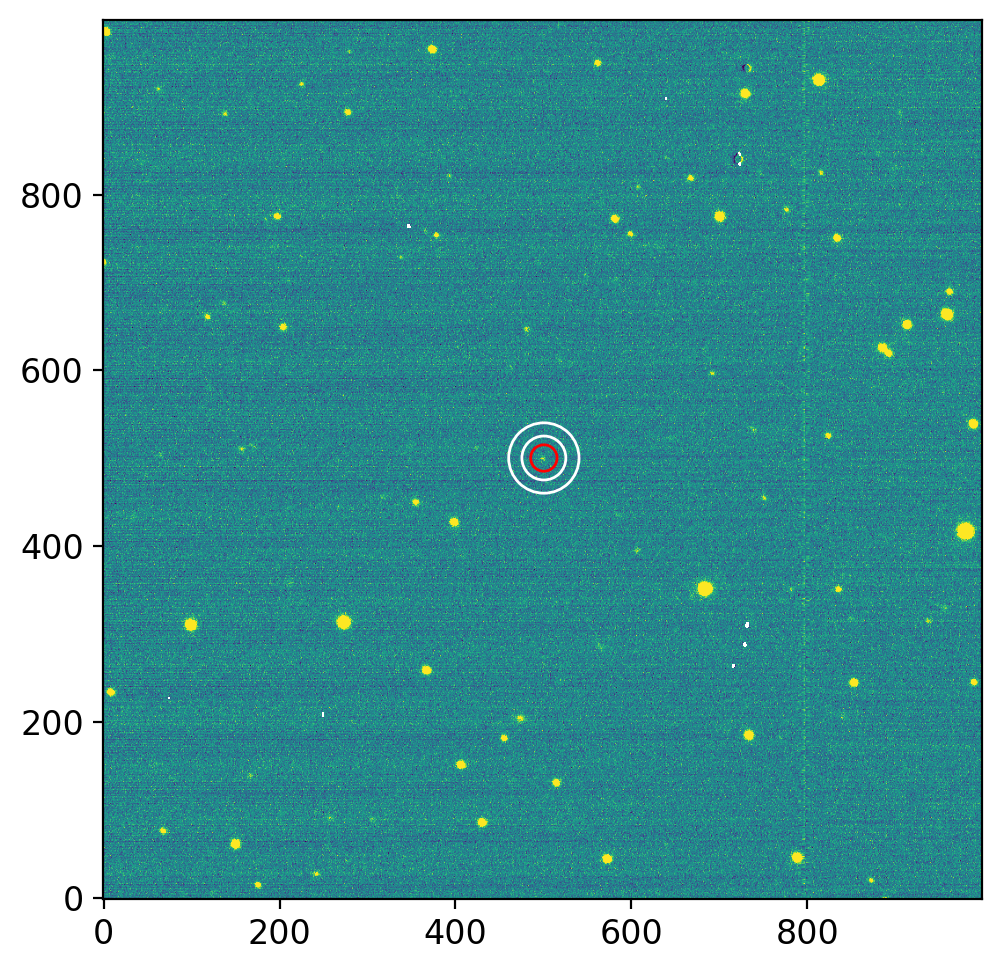

/Users/ysbach/Dropbox/github/ysphotutilpy/ysphotutilpy/apphot.py:222: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(_arr/gn + (rd/gn)**2)


Instrumental magntiude = -3.060 ± 0.346


In [5]:
pos_sky = SkyCoord(q_obj["RA"][0], q_obj["DEC"][0], unit='deg')
pos_pix = pos_sky.to_pixel(wcs=ccd.wcs)
pos_pix = np.array([pos_pix[0], pos_pix[1]]).T

ap0 = CircularAperture(pos_pix, r=15)
an0 = CircularAnnulus(pos_pix, r_in=25, r_out=40)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd, zscale=True)
ap0.plot(color='r', lw=1, alpha=1, ax=axs)
an0.plot(color='w', lw=1, alpha=1, ax=axs)
plt.tight_layout()
plt.show();

phot_targ = ypu.apphot_annulus(ccd, ap0, an0)
m_targ = phot_targ['mag'][0]
dm_targ = phot_targ['merr'][0]
print(f"Instrumental magntiude = {m_targ:.3f} ± {dm_targ:.3f}")

In [6]:
pix_scale = 0.4*u.arcsec
center_xy = np.array(ccd.shape)/2
center_radec = ccd.wcs.wcs_pix2world(*center_xy, 0)
center_coo = SkyCoord(*center_radec, unit='deg')
fov_radius = np.sqrt((np.array(ccd.shape)**2).sum())/2 * pix_scale
q_ps = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Panstarrs", 
                             data_release="dr2", table="mean")
# Change some column names for convenience.
q_ps["raMean"].name = "ra"
q_ps["decMean"].name = "dec"
q_ps["gMeanPSFMag"].name = "g"
q_ps["rMeanPSFMag"].name = "r"

# drop stars with unknown magnitudes
q_ps = q_ps.to_pandas().dropna(subset=["g", "r"])

# Calculate V and R, and their errors
q_ps["V"] = 0.006 + 0.474*q_ps["g"] + 0.526*q_ps["r"]
q_ps["R"] = -0.138 - 0.131*q_ps["g"] + 1.131*q_ps["r"]
q_ps["dV"] = np.sqrt(
    0.474**2*q_ps["gMeanPSFMagErr"]**2 
    + 0.526**2*q_ps["rMeanPSFMagErr"]**2 + 0.012**2
)
q_ps["dR"] = np.sqrt(
    0.131**2*q_ps["gMeanPSFMagErr"]**2
    + 1.131**2*q_ps["rMeanPSFMagErr"]**2 + 0.015**2
)
q_ps["dgr"] = np.sqrt(q_ps["gMeanPSFMagErr"]**2 + q_ps["rMeanPSFMagErr"]**2)

# Select only important columns
q2 = q_ps[["ra", "dec", "g", "r", "dgr", "V", "R", "dV", "dR"]].copy().reset_index(drop=True)

# Select only brighter than 22 mag
q2 = q2[(q2["V"] < 22) & (q2["R"] < 22)].copy()

# Calculate x, y position
coo = SkyCoord(q2["ra"], q2["dec"], unit='deg')
q2["x"], q2["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q2 = q2[(q2["x"] > 20) & (q2["x"] < ccd.shape[1]-20) 
        & (q2["y"] > 20) & (q2["y"] < ccd.shape[0]-20)]

q2 = q2.reset_index(drop=True)

print(f"Total {len(q2)} stars from PS1 DR2")

Total 122 stars from PS1 DR2


In [7]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.
finder = DAOStarFinder(
    fwhm=4,  # In reality, FWHM must be measured a priori using, e.g., `ginga`
    threshold=4 * std, 
    sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
    roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
    sigma_radius=1.5,           # default values 1.5
    ratio=1.0,                  # 1.0: circular gaussian
    exclude_border=True         # To exclude sources near edges
)

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
dao = finder(ccd.data - med)  
print(f"Total {len(dao)} stars from DAOStarFinder with threshold = {finder.threshold:.1f}")

Total 57 stars from DAOStarFinder with threshold = 34.9


In [8]:
def group_stars(table, crit_separation, xcol="x", ycol="y", index_only=True):
    ''' Group stars using DAOGROUP algorithm and return row indices.

    Parameters
    ----------
    table : astropy.table.Table
        The queried result table.

    crit_separation : float or int
        Distance, in units of pixels, such that any two stars separated by less
        than this distance will be placed in the same group.

    xcol, ycol : str, optional
        The column names for x and y positions. This is necessary since
        `~photutils.DAOGroup accepts a table which has x y positions designated
        as ``"x_0"`` and ``"y_0"``.

    index : bool, optional
        Whether to return only the index of the grouped rows (group information
        is lost) or the full grouped table (after group_by).

    Notes
    -----
    Assuming the psf fwhm to be known, ``crit_separation`` may be set to
    ``k * fwhm``, for some positive real k.

    See Also
    --------
    photutils.DAOStarFinder

    References
    ----------
    [1] Stetson, Astronomical Society of the Pacific, Publications,
        (ISSN 0004-6280), vol. 99, March 1987, p. 191-222.
        Available at: http://adsabs.harvard.edu/abs/1987PASP...99..191S

    Return
    ------
    gtab: Table
        Returned when ``index_only=False``. The table underwent
        ``.group_by("group_id")``.

    grouped_rows: list
        Returned when ``index_only=True``.
        The indices of the rows which are "grouped" stars. You may remove such
        rows using ``table.remove_rows(grouped_rows)``.
    '''

    # Convert to astropy.Table because DAOGroup only accepts astropy.Table.
    if not isinstance(table, Table):
        table = Table.from_pandas(table)
    tab = table.copy()

    tab[xcol].name = "x_0"
    tab[ycol].name = "y_0"
    try:
        gtab = DAOGroup(crit_separation=crit_separation)(tab)
    except IndexError:  # empty tab (len(tab) == 0)
        gtab = tab
        gtab["group_id"] = []
        gtab["id"] = []

    if not index_only:
        gtab["x_0"].name = xcol
        gtab["y_0"].name = ycol
        return gtab
    else:
        gid, gnum = np.unique(gtab["group_id"], return_counts=True)
        gmask = gid[gnum != 1]  # group id with > 1 stars
        grouped_rows = []
        for i, gid in enumerate(gtab["group_id"]):
            if gid in gmask:
                grouped_rows.append(i)
        return grouped_rows


rows2rm = group_stars(q2, crit_separation=20) 
q2_close = q2.drop(rows2rm, axis=0).reset_index(drop=True)

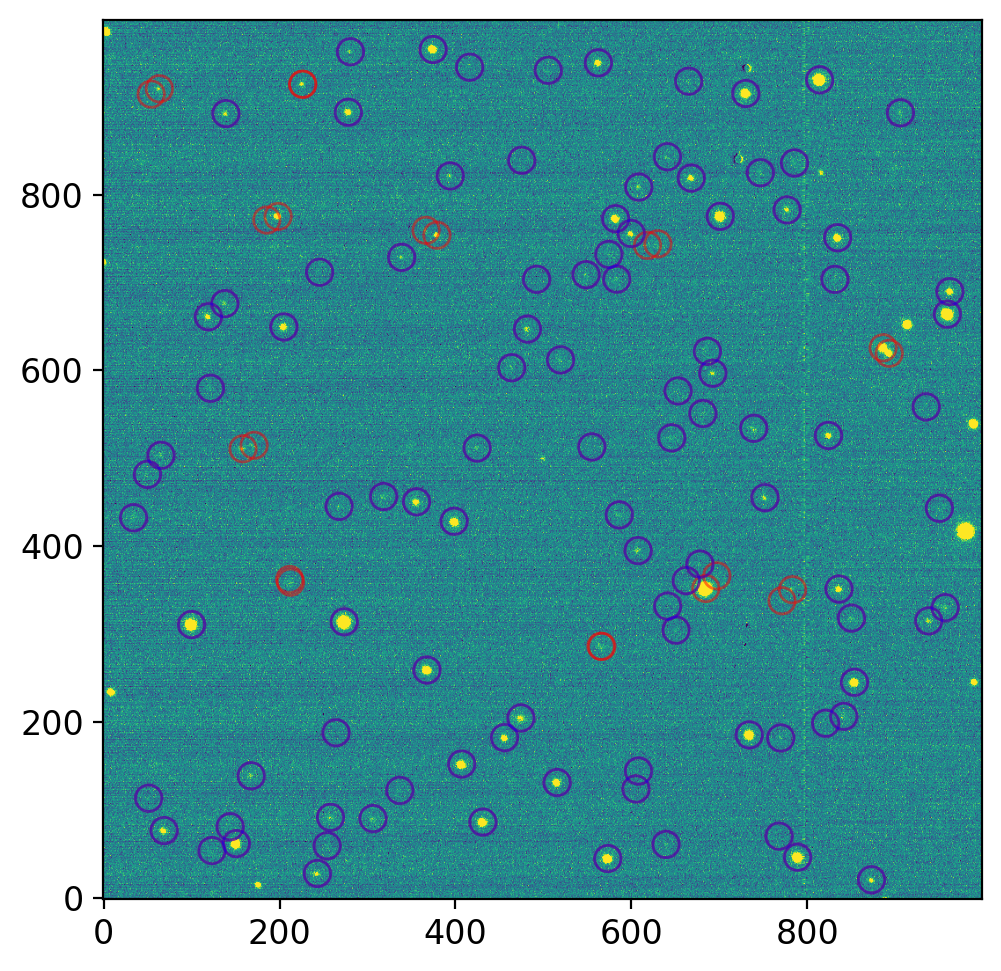

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

aps_all = CircularAperture(np.array([q2["x"], q2["y"]]).T, r=15)
aps_close = CircularAperture(np.array([q2_close["x"], q2_close["y"]]).T, r=15)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_all.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="blue", lw=1, alpha=0.5, ax=axs)

plt.tight_layout()
plt.show();

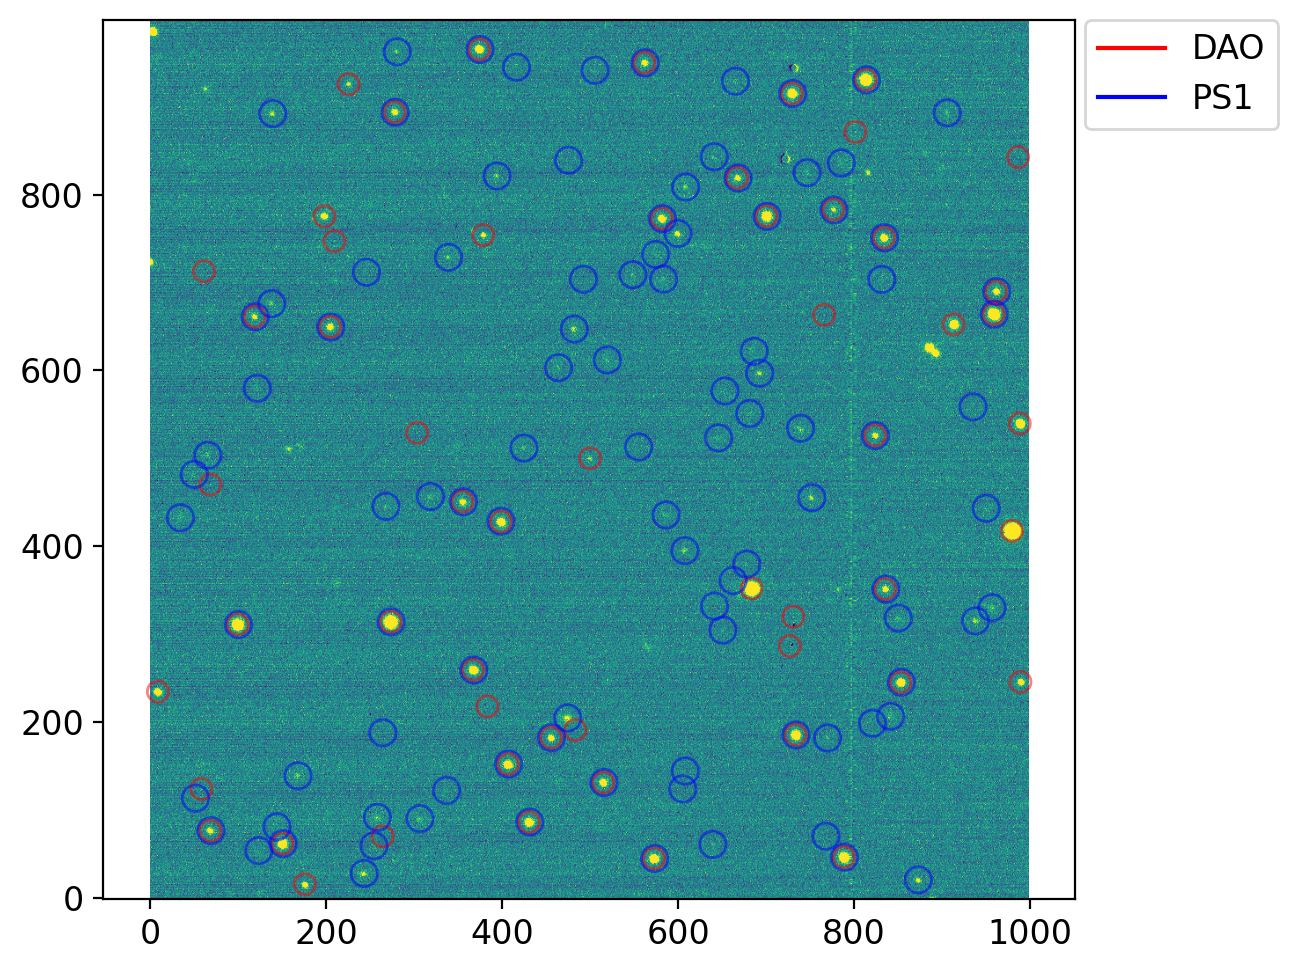

In [10]:
# Drop nearby objects
rows2rm = group_stars(dao, crit_separation=20, xcol="xcentroid", ycol="ycentroid")
dao = dao.to_pandas().drop(rows2rm, axis=0).reset_index(drop=True)

# Plot
aps_dao = CircularAperture(np.array((dao['xcentroid'], dao['ycentroid'])).T, r=12)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_dao.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="b", lw=1, alpha=0.5, ax=axs)
for c, l in zip("rb", ["DAO", "PS1"]):
    axs.plot([], [], c=c, label=l)
axs.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

In [11]:
q2_close["xcentroid"], q2_close["ycentroid"] = None, None

for i, row in q2_close.iterrows():
    x, y = row["x"], row["y"]
    # Find closest DAOStarFinder source with distance no larger than 5 pix
    dx = dao["xcentroid"] - x
    dy = dao["ycentroid"] - y
    candidate = dao[(abs(dx) < 5) & (abs(dy) < 5)]
    if len(candidate) == 0:
        continue

    # Find the closest one
    if len(candidate) > 1:
        candidate = candidate[np.argmin(np.hypot(dx, dy))]
    
    q2_close.loc[i, "xcentroid"] = candidate["xcentroid"].iloc[0]
    q2_close.loc[i, "ycentroid"] = candidate["ycentroid"].iloc[0]
q2_close = q2_close.dropna(axis=0, subset="xcentroid").reset_index(drop=True)

In [12]:
q2_xy = np.array([q2_close["xcentroid"], q2_close["ycentroid"]]).T
ap_stars = CircularAperture(q2_xy, r=15)
an_stars = CircularAnnulus(q2_xy, r_in=25, r_out=40)
phot = ypu.apphot_annulus(ccd, ap_stars, an_stars).drop(["xcenter", "ycenter"], axis=1)
phot = q2_close.join([phot])

/Users/ysbach/Dropbox/github/ysphotutilpy/ysphotutilpy/apphot.py:222: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(_arr/gn + (rd/gn)**2)


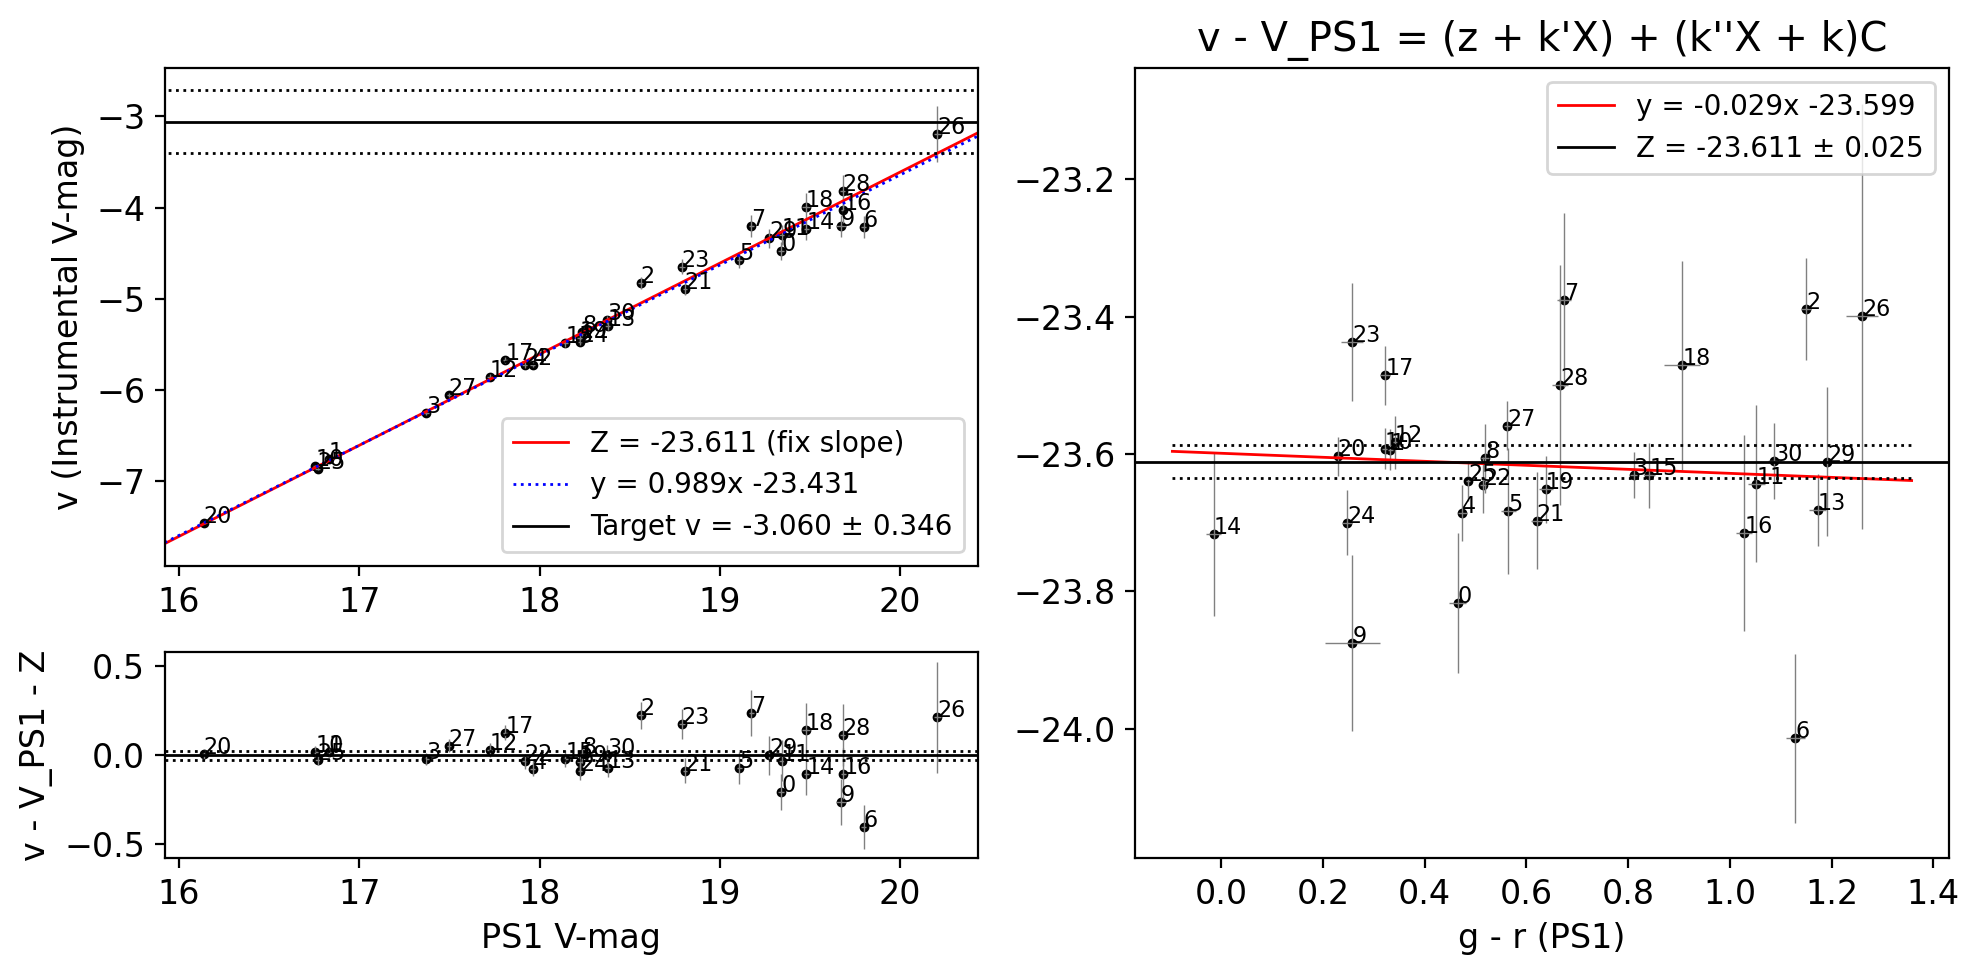

In [13]:
from scipy.optimize import curve_fit

def linf(x, a, b):
    return a + b*x

mcat, dmcat = phot["V"], phot["dV"]
mobs, dmobs = phot["mag"], phot["merr"]
color = phot["g"] - phot["r"]
dmtot = np.sqrt(dmcat**2 + dmobs**2)

# === Calculate zero point and errors
zeropt = np.average(mobs - mcat, weights=1/dmtot**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/dmtot**2)), np.std(mobs - mcat, ddof=1)/np.sqrt(len(mcat))])
dmtot2 = np.sqrt(dmtot**2 + dzeropt**2)

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
poptm, _ = curve_fit(linf, mcat, mobs, sigma=dmobs, absolute_sigma=True)
poptc, _ = curve_fit(linf, color, mobs-mcat, sigma=dmtot2, absolute_sigma=True)

# === Plot
# --- Set some useful things
errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

# --- Main plot with error bars and fitting lines
fig, axs = plt.subplot_mosaic("mc\nmc\nrc", figsize=(10, 5))
# m = magnitudes, c=colors, r=residuals
axs["m"].plot(mcat, mobs, "k.", ms=5)
axs["m"].errorbar(mcat, mobs, xerr=dmcat, yerr=dmobs, **errkw)
axs["r"].plot(mcat, mobs - mcat - zeropt, "k.", ms=5)
axs["r"].errorbar(mcat, mobs - mcat - zeropt, xerr=dmcat, yerr=dmtot2, **errkw)
axs["c"].plot(color, mobs - mcat, "k.", ms=5)
axs["c"].errorbar(color, mobs - mcat, xerr=phot["dgr"], yerr=dmtot2, **errkw)

mm = np.array(axs["m"].get_xlim())
cc = np.array(axs["c"].get_xlim())

# Fitted lines
axs["m"].plot(mm, zeropt + mm, "r-", lw=1, label=f"Z = {zeropt:+.3f} (fix slope)")
axs["m"].plot(mm, linf(mm, *poptm), "b:", lw=1, label=f"y = {poptm[1]:.3f}x {poptm[0]:+.3f}")
axs["c"].plot(cc, linf(cc, *poptc), "r-", lw=1, label=f"y = {poptc[1]:+.3f}x {poptc[0]:+.3f}")

# --- Some codes to make the plot prettier
axs["m"].axhline(m_targ, color="k", lw=1, label=f"Target v = {m_targ:.3f} ± {dm_targ:.3f}")
axs["m"].hlines([m_targ+dm_targ, m_targ-dm_targ], *axs["m"].get_xlim(), color="k", lw=1, ls=":")

for i, row in phot.iterrows():
    axs["m"].text(row["V"], row["mag"], i, fontsize=8)
    axs["r"].text(row["V"], row["mag"] - row["V"] - zeropt, i, fontsize=8)
    axs["c"].text(row["g"] - row["r"], row["mag"] - row["V"], i, fontsize=8)

axs["m"].set(xlim=mm, ylabel="v (Instrumental V-mag)")
axs["r"].set(xlim=mm, ylim=np.array([-1, 1])*np.max(np.abs(axs["r"].get_ylim())), 
             ylabel="v - V_PS1 - Z", xlabel="PS1 V-mag")
axs["c"].set(title="v - V_PS1 = (z + k'X) + (k''X + k)C", xlabel="g - r (PS1)")

axs["r"].axhline(0, color="k", lw=1)
axs["r"].hlines([dzeropt, -dzeropt], *mm, color="k", lw=1, ls=":" )
axs["c"].axhline(zeropt, color="k", lw=1, label=f"Z = {zeropt:.3f} ± {dzeropt:.3f}")
axs["c"].hlines([zeropt+dzeropt, zeropt-dzeropt], *cc, color="k", lw=1, ls=":" )

axs["m"].legend(fontsize=10)
axs["c"].legend(fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
phot_targ["V"] = phot_targ["mag"] - zeropt
phot_targ["dV"] = np.sqrt(phot_targ["merr"]**2 + dzeropt**2)
phot_targ[["xcenter", "ycenter", "snr", "V", "dV"]]

xcenter     ycenter       snr          V        dV
0  500.582912  500.435615  3.133608  20.550977  0.347353